In [1]:
import pandas as pd
import os
import seaborn as sns
from config import *
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [2]:
result_dir='algorithm_classification_ela_results'
seeds=[200,400,600,800,1000]
visualizations_dir='algorithm_classification_ela_visualizations'
train_on_seed=True
difference=False

seed_mapping={index:seed for index,seed in enumerate(seeds)}

In [3]:
os.makedirs(visualizations_dir,exist_ok=True)

In [4]:
def get_global_file_name(dimension,algorithms, iteration_start,iteration_end, train_on_seed,seed, difference,stat=None):
    file_name=f'dim_{dimension}_{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_100_{"train" if train_on_seed else "test"}_on_seed_{seed}{"_differenced" if difference else ""}'
    if stat is None:
        return os.path.join(result_dir,file_name)
    else:
        return os.path.join(result_dir,f'stat_{stat}_' + file_name)


def get_visualization_output_name_without_seed(dimension,algorithms, iteration_start,iteration_end, train_on_seed, difference):
    return os.path.join(visualizations_dir,f'dim_{dimension}_{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_100_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}')

In [5]:
def get_seed_accuracies_df(dimension,algorithm, iteration_start, iteration_end, train_on_seed, difference, seeds, stat=None):
    seed_accuracies=[]
    test_df_all=pd.DataFrame()
    for train_seed in seeds:
        test_df=pd.DataFrame()
        for fold in range(0,10):

            global_file_name=get_global_file_name(dimension,algorithm, iteration_start,iteration_end, train_on_seed,train_seed, difference, stat)
            file_location=global_file_name+f'_fold_{fold}_test_preds.csv'

            if not os.path.isfile(file_location):
                print('Not found', file_location)
                continue
            #print(file_location)
            test_df_fold=pd.read_csv(file_location, index_col=[0], compression='zip').rename(columns={'seed':'test_seed'}) 
            test_df_fold['fold']=fold
            test_df_fold['train_seed']=train_seed
            test_df=pd.concat([test_df,test_df_fold])
            test_df_all=pd.concat([test_df_all,test_df_fold])



        for test_seed in seeds:
            for fold in range(0,10):
                seed_preds_df=test_df.query('test_seed==@test_seed and fold==@fold')
                seed_accuracies+=[(accuracy_score(seed_preds_df['y'], seed_preds_df['preds']), train_seed, test_seed, fold)]


    if len(seed_accuracies)>0:
        seed_accuracy_df=pd.DataFrame(seed_accuracies)
        seed_accuracy_df.columns=['accuracy','train_seed','test_seed','fold']
        return seed_accuracy_df, test_df_all
    return None

In [6]:
def accuracy_subplots(all_accuracies, all_groupings, group_name, file_name):
    fig, axes = plt.subplots(int(len(all_groupings)/2),2, figsize=(8,8), sharex=True, sharey=True, squeeze=False)
    for grouping_index, grouping in enumerate(all_groupings):
        grouping_accuracies=all_accuracies[all_accuracies[group_name]==grouping]
        ax=axes[int(grouping_index/2), grouping_index%2] if type(axes) is np.ndarray else axes
        ax.set_title(f'{group_name}: {grouping}')
        sns.violinplot(data=grouping_accuracies, x="feature calculation budget (iterations)", y="accuracy", hue='Evaluation on trajectories from training seed', split=True, palette=color_palette[1:3], ax=ax)
        if grouping_index != 0:
            ax.get_legend().remove()
    plt.tight_layout()

    plt.savefig(os.path.join(visualizations_dir,file_name))
    plt.show()

In [ ]:
results_per_iteration=[]
all_algorithms='DE_PSO_ES'
all_dimensions=[3,5,10,20]
all_accuracies=pd.DataFrame()
difference=False
train_on_seed=True
end_iterations=[2,9,19,29,39,49]

fig, axes = plt.subplots(len(all_dimensions),len(end_iterations), figsize=(24,12), squeeze=False)
for dimension_index, dimension in enumerate(all_dimensions):

    for end_iteration_index, end_iteration in enumerate(end_iterations):
        _,predictions = get_seed_accuracies_df(dimension,all_algorithms, 0, end_iteration, train_on_seed, difference, seeds)
        ax=axes[dimension_index][end_iteration_index]
        ax.set_title(f'Feature calculation \n budget: {end_iteration + 1}')
        d=ConfusionMatrixDisplay.from_predictions(predictions['y'],predictions['preds'],cmap=my_cmap, colorbar=True,ax=ax)

                
rows=[f'Dimension: {d}' for d in all_dimensions]      
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation= 90)
    
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir,f'confusion_matrices_per_iteration_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}.pdf'))
plt.show()

In [15]:
results_per_iteration=[]
all_algorithms='DE_PSO_ES'
all_dimensions=[5]
all_accuracies=pd.DataFrame()
train_on_seed=True
for dimension in all_dimensions:

    for end_iteration in [0,2,9,19,29]:
        for difference_index, difference in enumerate([False,True]):
            seed_accuracy_df,_ = get_seed_accuracies_df(dimension,all_algorithms, 0, end_iteration, train_on_seed, difference, seeds)
            seed_accuracy_df['feature calculation budget (iterations)']=end_iteration+1
            seed_accuracy_df['dimension']=dimension
            seed_accuracy_df['difference']=difference
            all_accuracies=pd.concat([all_accuracies,seed_accuracy_df])

    
all_accuracies['Evaluation on trajectories from training seed']=all_accuracies.apply(lambda row: row['train_seed']==row['test_seed'] if train_on_seed else row['train_seed']!=row['test_seed'] , axis=1)
print(all_accuracies)
#accuracy_subplots(all_accuracies,all_dimensions,'dimension',f'accuracy_by_dimension_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}.pdf')

     accuracy  train_seed  test_seed  fold  \
0    0.754444         200        200     0   
1    0.793333         200        200     1   
2    0.795556         200        200     2   
3    0.795556         200        200     3   
4    0.808333         200        200     4   
..        ...         ...        ...   ...   
245  1.000000        1000       1000     5   
246  1.000000        1000       1000     6   
247  1.000000        1000       1000     7   
248  0.991667        1000       1000     8   
249  1.000000        1000       1000     9   

     feature calculation budget (iterations)  dimension  difference  \
0                                          1          5       False   
1                                          1          5       False   
2                                          1          5       False   
3                                          1          5       False   
4                                          1          5       False   
..                   

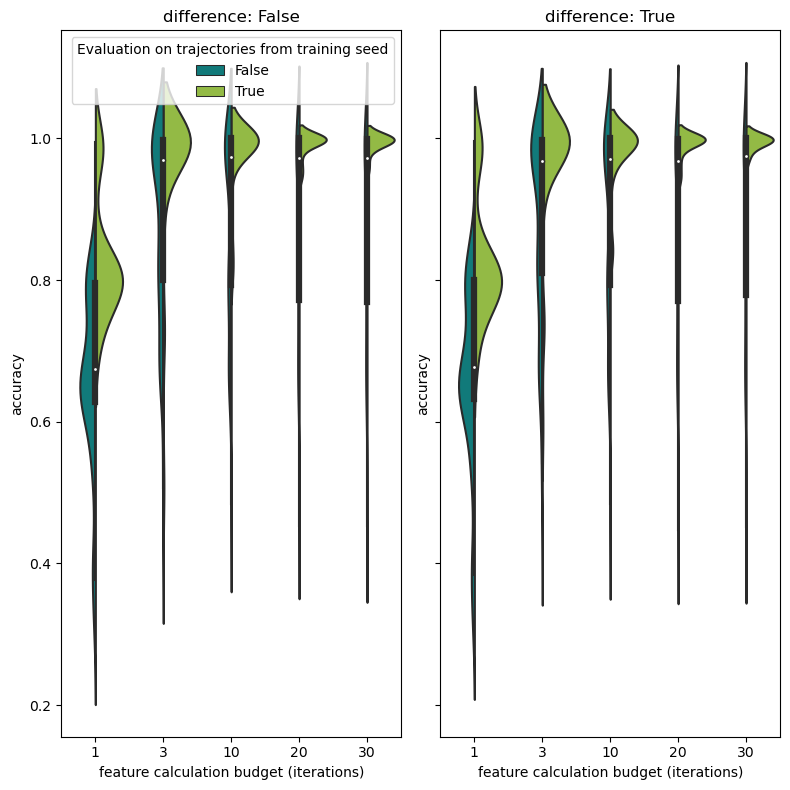

In [16]:
accuracy_subplots(all_accuracies,[False,True],'difference',f'accuracy_by_difference_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}.pdf')

In [ ]:
all_accuracies_file=os.path.join(visualizations_dir,'all_accuracies.csv')
if not os.path.isfile(all_accuracies_file):
    print('recalculating accuracies')
    all_algorithms='DE_PSO_ES_CMAES'
    all_dimensions=[3,5,10,20]

    all_accuracies=pd.DataFrame()
    for train_on_seed in [True,False]:
        for difference in [False, True]:
            for dimension in all_dimensions:

                for end_iteration in [2,9,19,29,39,49]:
                    seed_accuracy_df,_ = get_seed_accuracies_df(dimension,all_algorithms, 0, end_iteration, train_on_seed, difference, seeds)
                    seed_accuracy_df['feature calculation budget']=end_iteration+1
                    seed_accuracy_df['dimension']=dimension
                    seed_accuracy_df['difference']=difference
                    seed_accuracy_df['train_on_seed']=train_on_seed
                    seed_accuracy_df['Same seed results']=seed_accuracy_df.apply(lambda row: row['train_seed']==row['test_seed'] if train_on_seed else row['train_seed']!=row['test_seed'] , axis=1)
                    
                    all_accuracies=pd.concat([all_accuracies,seed_accuracy_df])


    
    all_accuracies.to_csv(os.path.join(visualizations_dir,'all_accuracies.csv'))

else:
    all_accuracies=pd.read_csv(all_accuracies_file, index_col=0)


In [ ]:
axes_row=-1
fig, axes = plt.subplots(4,4, figsize=(12,12), sharex=True, sharey=True, squeeze=False)
for train_on_seed in [True,False]:
    for difference in [False, True]:
        axes_row+=1
        
        setting_accuracies=all_accuracies.query('train_on_seed==@train_on_seed and difference==@difference')

        for dimension_index, dimension in enumerate(all_dimensions):
            dimension_accuracies=setting_accuracies.query('dimension==@dimension')
            ax=axes[axes_row, dimension_index] if type(axes) is np.ndarray else axes
            ax.set_title(f'Dimension: {dimension}')
            sns.violinplot(data=dimension_accuracies, x="feature calculation budget", y="accuracy", hue='Same seed results', split=True, palette=color_palette[1:3], ax=ax)
            if dimension_index != 0 or axes_row!=0:
                ax.get_legend().remove()
                
rows=['Experimental setting 1,\n original features', 'Experimental setting 1,\n differenced features','Experimental setting 2,\n original features','Experimental setting 2,\n differenced features']      
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation= 90)
                
plt.tight_layout()

plt.savefig(os.path.join(visualizations_dir,'all_dimensions_all_iterations.pdf'))
plt.show()

Empty DataFrame
Columns: [seed, fold, budget, variable, value]
Index: []


/tmp/ipykernel_311384/2064809570.py:31: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  top_features=all_feature_importances_df.drop(columns=id_vars).median().sort_values(ascending=False).head(30)


ValueError: min() arg is an empty sequence

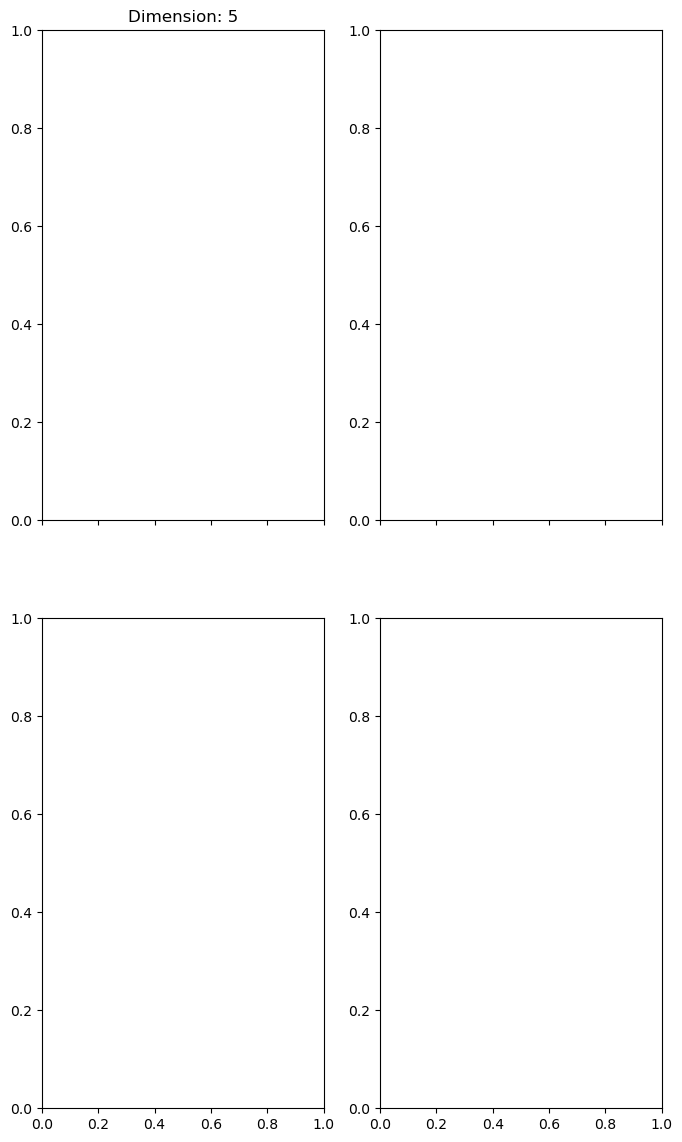

In [17]:
fig, axes = plt.subplots(2,2, figsize=(8,14), sharex=True)
end_iteration=29
for dimension_index,dimension in enumerate([5]):
        
    all_feature_importances_df=pd.DataFrame()
    for seed in seeds:

        for difference in [False]:

             for fold in range(0,10):
                global_file_name=get_global_file_name(dimension,all_algorithms, 0, end_iteration,True, seed, difference)
                file_location=global_file_name+f'_fold_{fold}_feature_importance.csv'

                if not os.path.isfile(file_location):
                    print('Not found', file_location)
                    continue
                #print(file_location)
                fold_importance_df=pd.read_csv(file_location, index_col=[0], compression='zip')
                fold_importance_df['seed']=seed
                fold_importance_df['fold']=fold
                fold_importance_df['budget']=end_iteration+1
                all_feature_importances_df=pd.concat([all_feature_importances_df, fold_importance_df])

    all_feature_importances_df.columns=[c.replace('_dim_','_x_') if f'_dim_{dimension}' not in c else c.replace(f'_dim_{dimension}','_y') for c in all_feature_importances_df.columns]

    ax=axes[int(dimension_index/2), dimension_index%2] if type(axes) is np.ndarray else axes
    ax.set_title(f'Dimension: {dimension}')
    
    id_vars=['seed','fold','budget']
    
    top_features=all_feature_importances_df.drop(columns=id_vars).median().sort_values(ascending=False).head(30)

    top_features=list(top_features.index)


    all_feature_importances_df_melted=pd.melt(all_feature_importances_df[top_features+id_vars], id_vars=id_vars, value_vars=top_features)
    print(all_feature_importances_df_melted)
    sns.barplot(all_feature_importances_df_melted, y='variable',x='value',palette=color_palette, ax=ax, estimator='median')
    ax.set_xlabel('feature importance')
    ax.set_ylabel('feature')
plt.tight_layout()

plt.savefig(os.path.join(visualizations_dir,'feature_importance_per_dimension.pdf'))
plt.show()

In [ ]:
id_vars=['algorithm','seed','fold']
top_30_features=list(all_feature_importances_df.drop(columns=id_vars).median().sort_values(ascending=False).head(30).index)


all_feature_importances_df_melted=pd.melt(all_feature_importances_df[top_30_features+id_vars], id_vars=id_vars, value_vars=top_30_features)
plt.figure(figsize=(6,9))

sns.barplot(all_feature_importances_df_melted, y='variable',x='value',palette=color_palette)
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir,'top_30_feature_importance.pdf'))

In [ ]:
if iteration_end<10:
    all_feature_importances_df_melt=pd.melt(all_feature_importances_df, id_vars=['seed','fold'],value_vars=list(set(all_feature_importances_df.columns).difference({'seed','fold'})), value_name='Importance', var_name='Feature')

    all_feature_importances_df_melt['Feature type']=all_feature_importances_df_melt['Feature'].apply(lambda x: x.split(' ')[0])
    all_feature_importances_df_melt['Iteration']=all_feature_importances_df_melt['Feature'].apply(lambda x: int(x.split(' ')[1].split('_')[1]))
    all_feature_importances_df_melt['Feature aggregated across dimensions']=all_feature_importances_df_melt['Feature'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1].split('_')[1])

    all_feature_importances_df_melt=all_feature_importances_df_melt.sort_values(['Iteration','Feature type'])

    #plt.figure(figsize=(40,10))
    fig, axes= plt.subplots(1,1,figsize=(10,3), sharey=True)
    sns.boxplot(all_feature_importances_df_melt.query('Iteration<10'),y='Importance', x='Feature aggregated across dimensions',  palette=color_palette_4, ax=axes)
    axes.tick_params(axis='x', labelrotation=90)

    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir,f'{algorithms}_{iteration_start}-{iteration_end}_feature_importance_across_iterations.pdf'))

In [ ]:
if iteration_end>20:
    all_feature_importances_df_melt=pd.melt(all_feature_importances_df, id_vars=id_vars,value_vars=list(set(all_feature_importances_df.columns).difference(set(id_vars))), value_name='Importance', var_name='Feature')

    all_feature_importances_df_melt['Feature type']=all_feature_importances_df_melt['Feature'].apply(lambda x: x.split(' ')[0])
    all_feature_importances_df_melt['Iteration']=all_feature_importances_df_melt['Feature'].apply(lambda x: int(x.split(' ')[1].split('_')[1]))
    all_feature_importances_df_melt['Feature aggregated across dimensions']=all_feature_importances_df_melt['Feature'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1].split('_')[1])

    all_feature_importances_df_melt=all_feature_importances_df_melt.sort_values(['Iteration','Feature type'])

    #plt.figure(figsize=(40,10))
    fig, axes= plt.subplots(3,1,figsize=(10,8), sharey=True)
    sns.boxplot(all_feature_importances_df_melt.query('Iteration<10'),y='Importance', x='Feature aggregated across dimensions',  palette=[color_palette_4[1]], ax=axes[0])
    sns.boxplot(all_feature_importances_df_melt.query('Iteration>=10 and Iteration <20'),y='Importance', x='Feature aggregated across dimensions',  palette=[color_palette_4[1]], ax=axes[1])

    sns.boxplot(all_feature_importances_df_melt.query('Iteration>=20'),y='Importance', x='Feature aggregated across dimensions',  palette=[color_palette_4[1]], ax=axes[2])
    axes[0].tick_params(axis='x', labelrotation=90)
    axes[1].tick_params(axis='x', labelrotation=90)
    axes[2].tick_params(axis='x', labelrotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir,f'all_algs_{iteration_start}-{iteration_end}_feature_importance_across_iterations.pdf'))

In [ ]:
top_feature_importances=[]
feature_importance_scores=pd.DataFrame()
for seed in seeds:
    seed_feature_importances_df=all_feature_importances_df.query('seed==@seed')
    sorted_feature_importance=seed_feature_importances_df.drop(columns=['seed']).median().sort_values(ascending=False).to_frame()
    top_features = list(sorted_feature_importance.index)[:20]+['seed']
    
    sorted_feature_importance['rank']=list(range(0,sorted_feature_importance.shape[0]))
    
    sorted_feature_importance['seed']=seed
    feature_importance_scores=pd.concat([feature_importance_scores,sorted_feature_importance.reset_index()])
    top_feature_importances+=top_features
    all_feature_importances=[]
    for index, row in seed_feature_importance_df[top_features ].iterrows():
        for index2 in row.keys():
            if index2!='seed':
                all_feature_importances+=[(index,index2,row[index2],row['seed'])]
    feature_importance_df=pd.DataFrame(all_feature_importances, columns=['fold','feature_name','importance','seed'])
    plt.figure()
    sns.boxplot(feature_importance_df,y='importance', x='feature_name',  palette=color_palette)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir,f'{algorithms}_{iteration_start}-{iteration_end}_final_top_20_features_boxplots_seeds_{seed}.pdf'))
print(pd.DataFrame(top_feature_importances).value_counts())
print(feature_importance_scores)
    